In [1]:
# load required libraries
library(tidyverse)
library(janitor)
library(dplyr)
library(ggplot2)
library(skimr)
library(purrr)
library(lubridate)

source("../../R/apply_factors.R")
source("../../R/analysis_helpers.R")
source("../../R/temporal_helpers.R")
tables <- list(
  Orders   = readr::read_csv("../../data/processed/Orders.csv"),
  Returns  = readr::read_csv("../../data/processed/Returns.csv"),
  People   = readr::read_csv("../../data/processed/People.csv")
)
tables <- apply_factors(tables)
orders <- tables$Orders 
returns <- tables$Returns
people <- tables$People

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Rows: 51290 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (13): order_id, ship_mode, customer_name, segment, state, country, mark...
dbl   (6): sales, quantity, discount, profit, shipping_cost, year
date  (2): order_date, ship_date

ℹ Use `spec()` to retrieve the full column specification f

# Executive Overview (Segment-Level)

### Total Sales by Segment

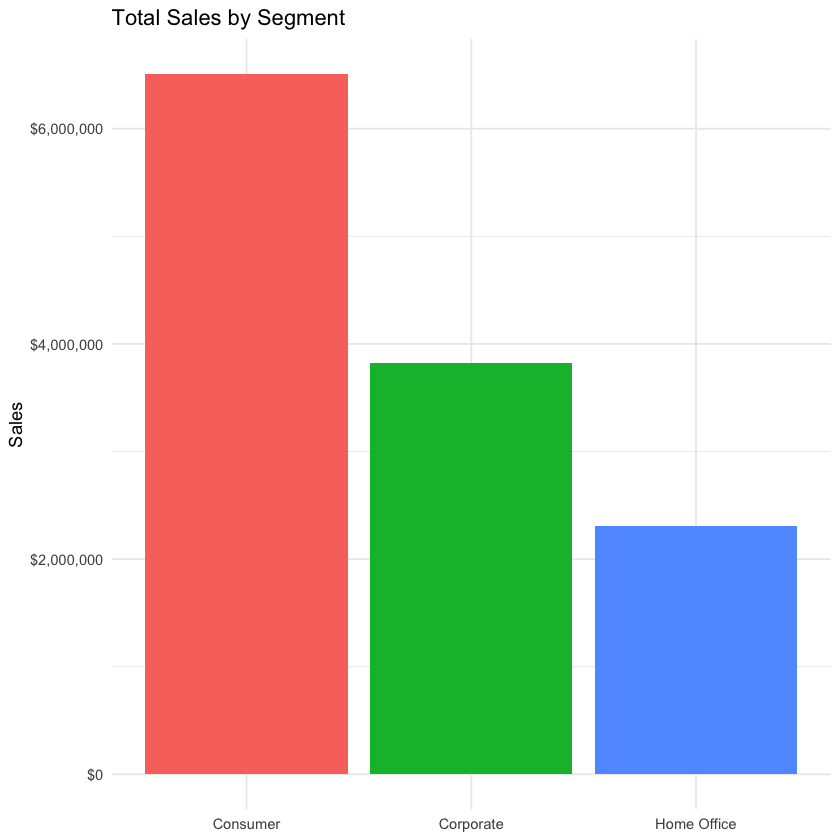

In [2]:
orders %>%
    group_by(segment) %>%
    summarise(total_sales = sum(sales)) %>%
    ggplot(aes(segment, total_sales, fill = segment)) +
    geom_col() +
    scale_y_continuous(labels = scales::dollar_format()) +
    labs(title = "Total Sales by Segment", x = NULL, y = "Sales") +
    theme_minimal() +
    theme(legend.position = "none")

### Total Profit by Segment

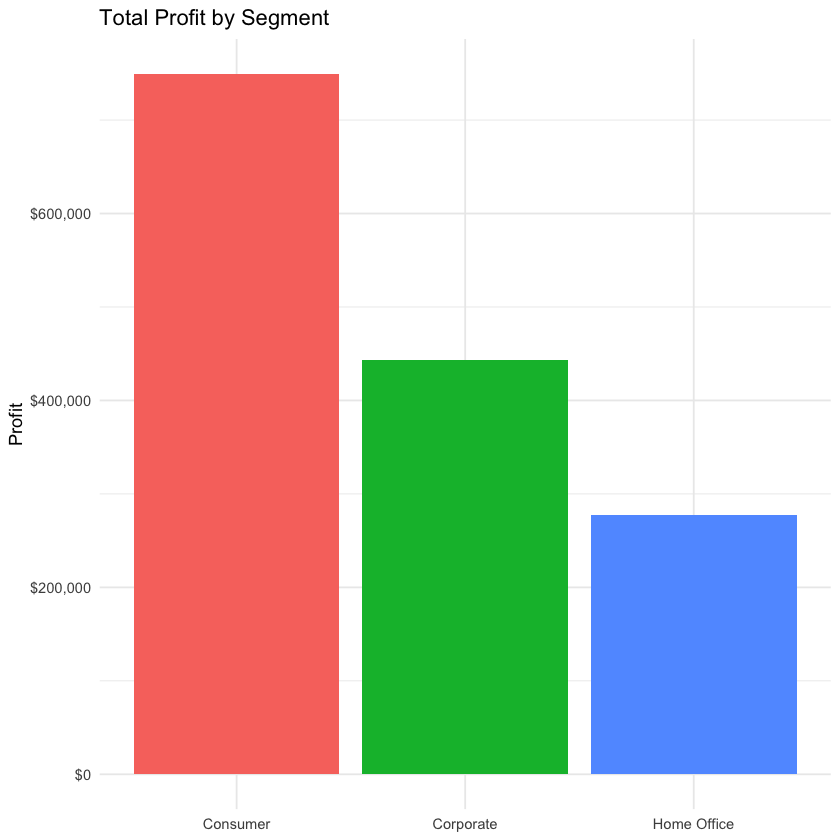

In [3]:
orders %>%
    group_by(segment) %>%
    summarise(total_profit = sum(profit)) %>%
    ggplot(aes(segment, total_profit, fill = segment)) +
    geom_col() +
    scale_y_continuous(labels = scales::dollar_format()) +
    labs(title = "Total Profit by Segment", x = NULL, y = "Profit") +
    theme_minimal() +
    theme(legend.position = "none")

### Profit Margin by Segment

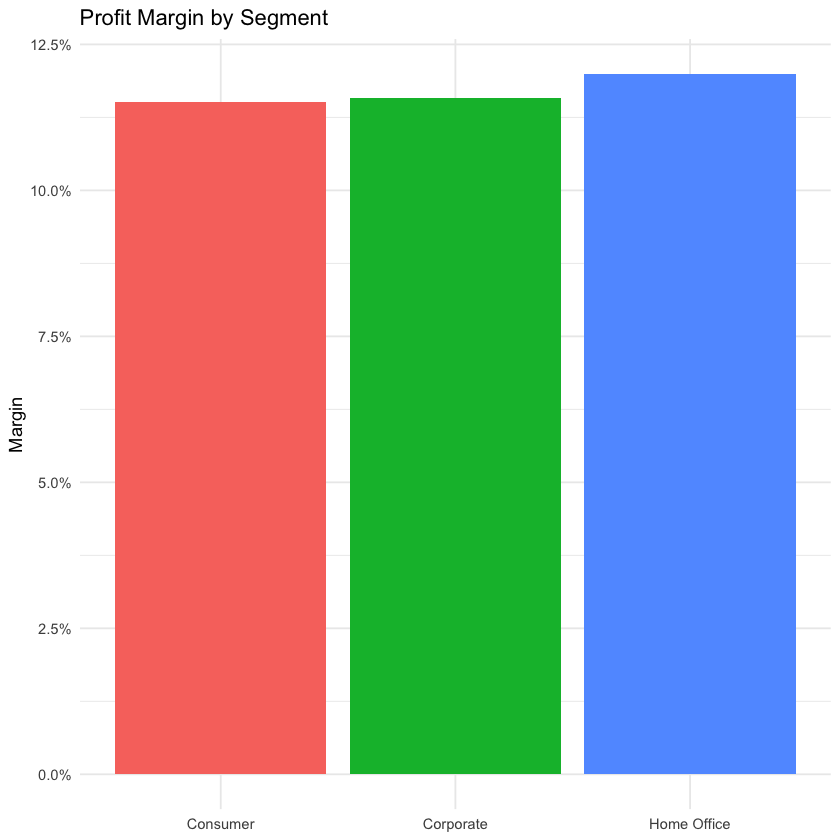

In [4]:
orders %>%
    group_by(segment) %>%
    summarise(margin = sum(profit) / sum(sales)) %>%
    ggplot(aes(segment, margin, fill = segment)) +
    geom_col() +
    scale_y_continuous(labels = scales::percent) +
    labs(title = "Profit Margin by Segment", x = NULL, y = "Margin") +
    theme_minimal() +
    theme(legend.position = "none")

### Orders by Segment

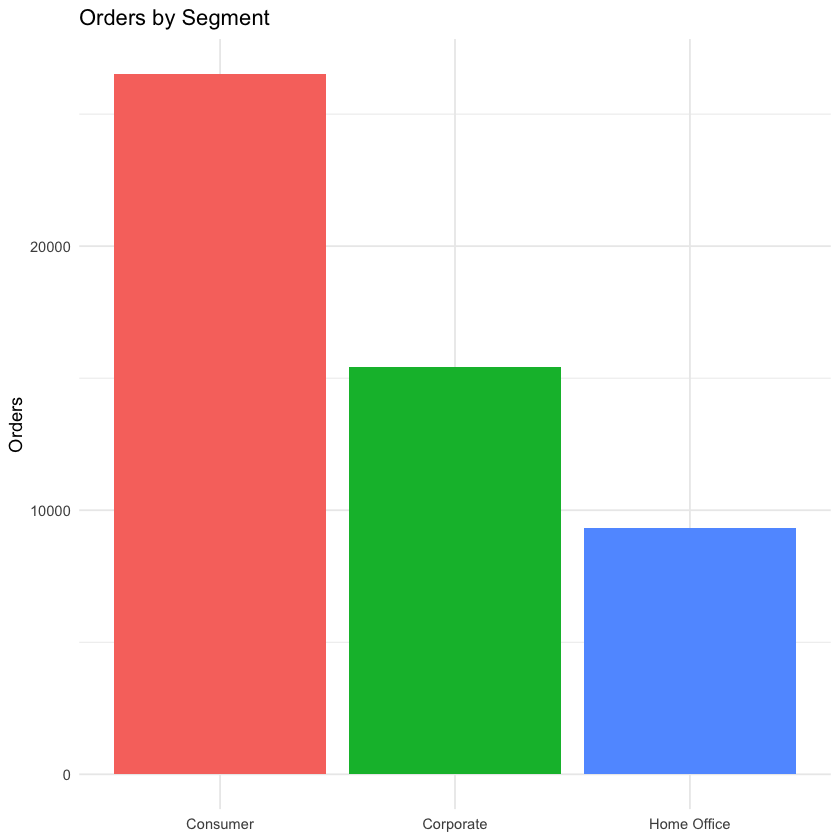

In [5]:
orders %>%
    count(segment, name = "orders") %>%
    ggplot(aes(segment, orders, fill = segment)) +
    geom_col() +
    labs(title = "Orders by Segment", x = NULL, y = "Orders") +
    theme_minimal() +
    theme(legend.position = "none")

# Segment Performance Profile

### Sales vs Profit by Segment (scatter)

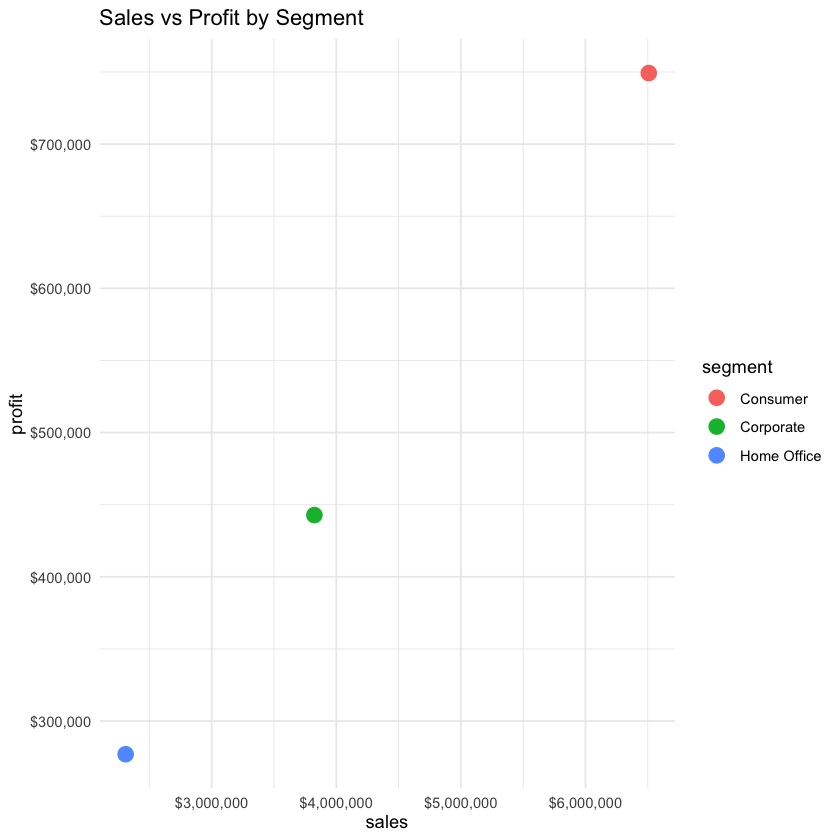

In [6]:
orders %>%
    group_by(segment) %>%
    summarise(
        sales = sum(sales),
        profit = sum(profit)
    ) %>%
    ggplot(aes(sales, profit, color = segment)) +
    geom_point(size = 4) +
    scale_x_continuous(labels = scales::dollar_format()) +
    scale_y_continuous(labels = scales::dollar_format()) +
    labs(title = "Sales vs Profit by Segment") +
    theme_minimal()

### Orders vs Sales by Segment (scatter)

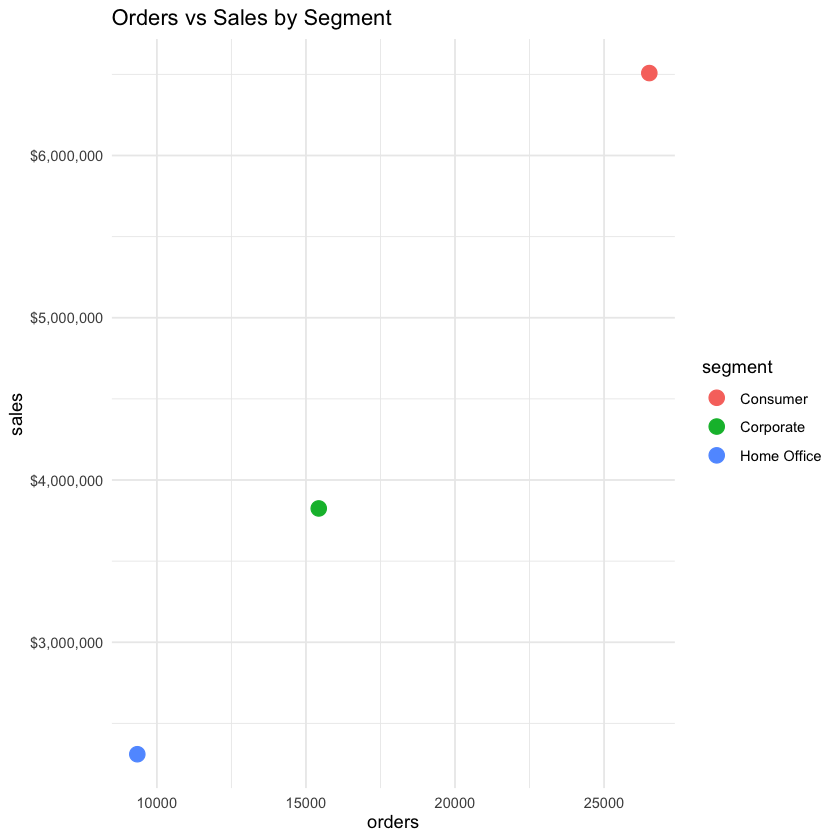

In [7]:
orders %>%
    group_by(segment) %>%
    summarise(
        sales = sum(sales),
        orders = n()
    ) %>%
    ggplot(aes(orders, sales, color = segment)) +
    geom_point(size = 4) +
    scale_y_continuous(labels = scales::dollar_format()) +
    labs(title = "Orders vs Sales by Segment") +
    theme_minimal()

### Average Order Value (AOV) by Segment

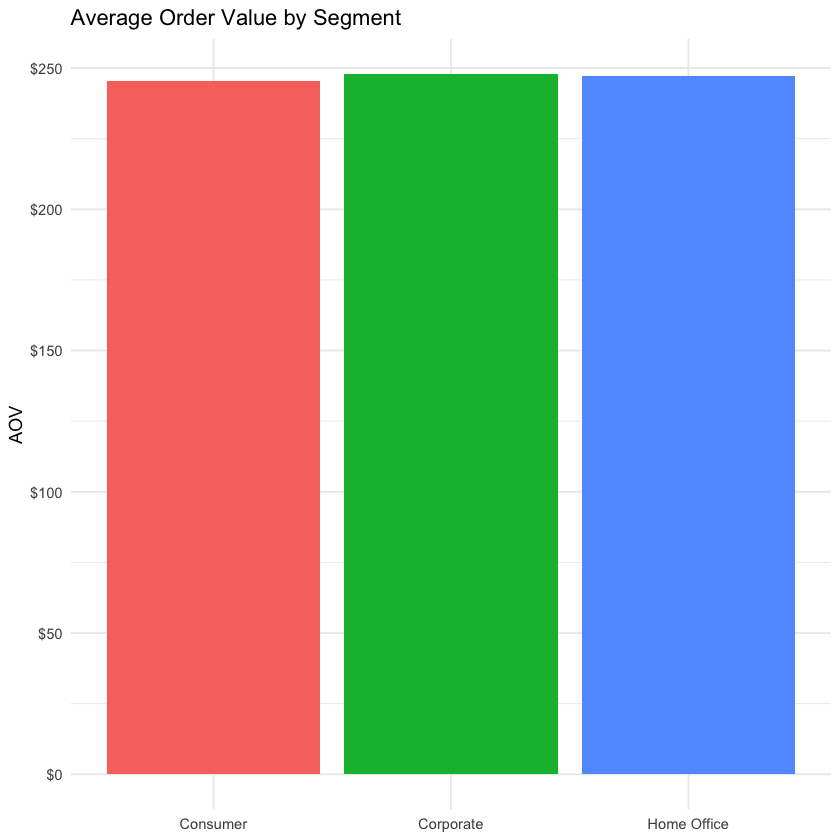

In [8]:
orders %>%
    group_by(segment) %>%
    summarise(aov = sum(sales) / n()) %>%
    ggplot(aes(segment, aov, fill = segment)) +
    geom_col() +
    scale_y_continuous(labels = scales::dollar_format()) +
    labs(title = "Average Order Value by Segment", x = NULL, y = "AOV") +
    theme_minimal() +
    theme(legend.position = "none")

# Product mix within Segments

### Category share of segment sales

`summarise()` has grouped output by 'segment'. You can override using the
`.groups` argument.


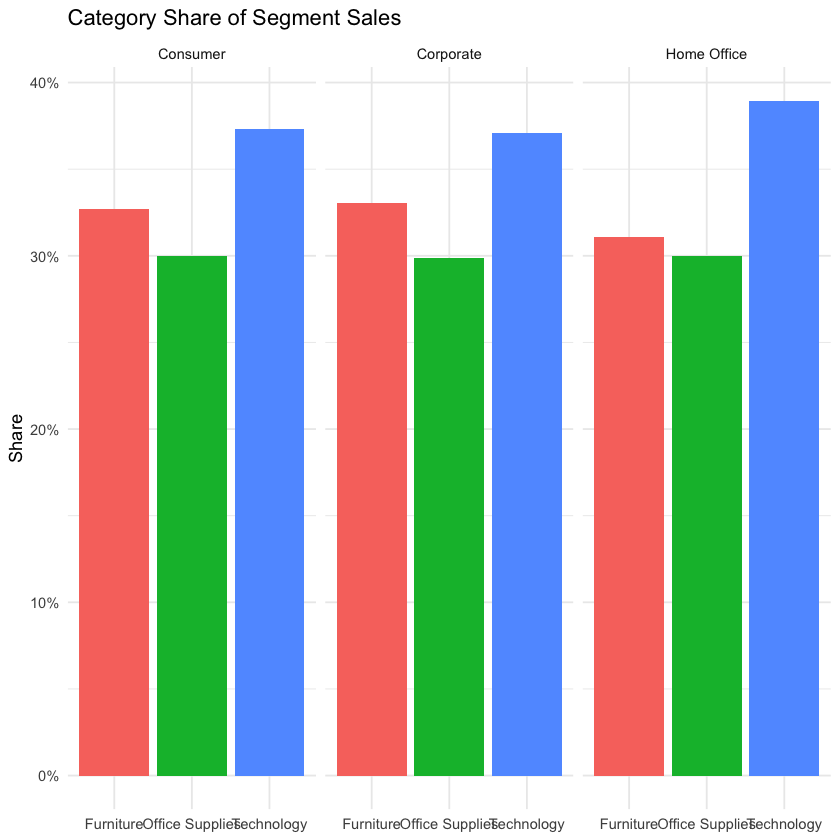

In [9]:
orders %>%
    group_by(segment, category) %>%
    summarise(sales = sum(sales)) %>%
    group_by(segment) %>%
    mutate(share = sales / sum(sales)) %>%
    ggplot(aes(category, share, fill = category)) +
    geom_col() +
    facet_wrap(~ segment) +
    scale_y_continuous(labels = scales::percent) +
    labs(title = "Category Share of Segment Sales", x = NULL, y = "Share") +
    theme_minimal() +
    theme(legend.position = "none")

### Sub-category share of segment sales

`summarise()` has grouped output by 'segment'. You can override using the
`.groups` argument.


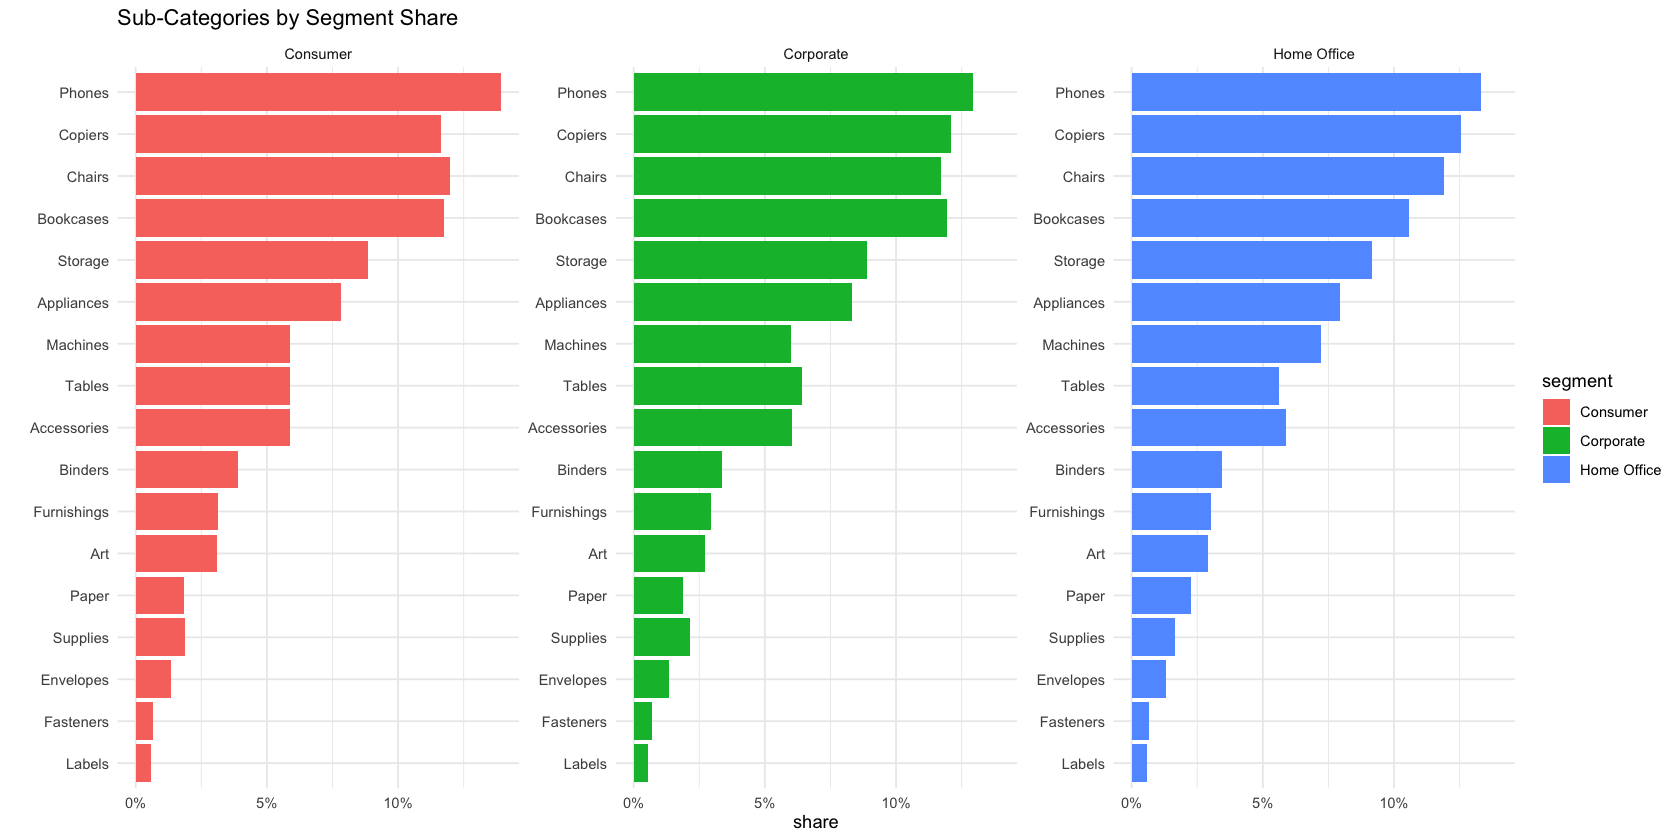

In [49]:
orders %>%
    group_by(segment, sub_category) %>%
    summarise(sales = sum(sales)) %>%
    group_by(segment) %>%
    mutate(share = sales / sum(sales)) %>%
    ggplot(aes(reorder(sub_category, share), share, fill = segment)) +
    geom_col() +
    coord_flip() +
    facet_wrap(~ segment, scales = "free_y") +
    scale_x_discrete("") +
    scale_y_continuous(labels = scales::percent) +
    labs(title = "Sub-Categories by Segment Share") +
    theme_minimal()


### Top/bottom N products by sales (per segment)

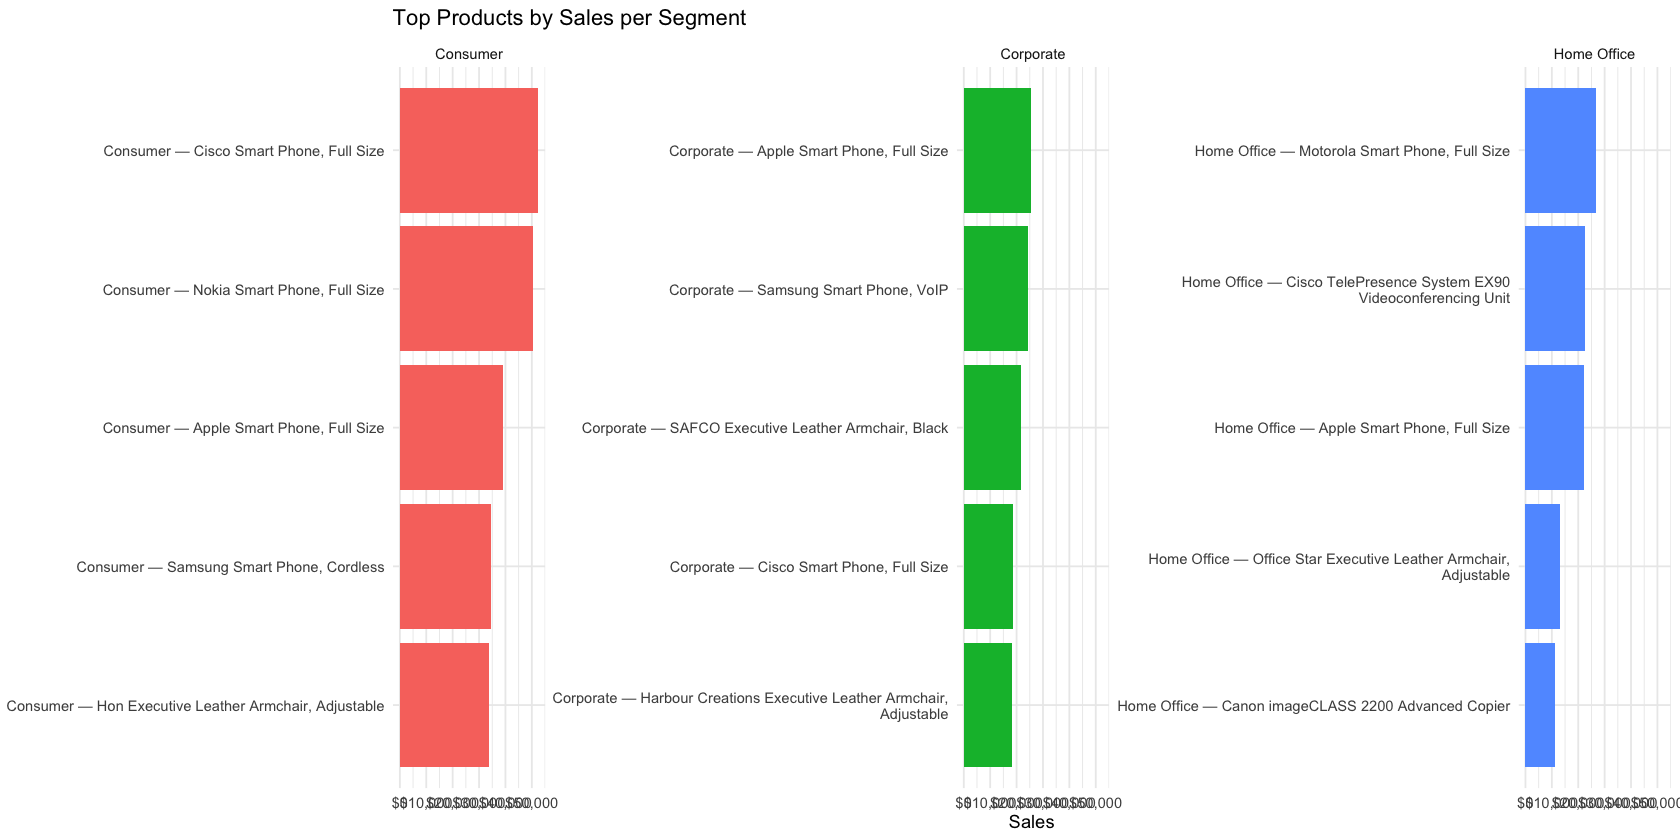

In [ ]:
N <- 5

top_products <- orders %>%
  group_by(segment, product_name) %>%
  summarise(sales = sum(sales), .groups = "drop") %>%
  group_by(segment) %>%
  slice_max(sales, n = N, with_ties = FALSE) %>%
  ungroup() %>%
  mutate(product_in_segment = paste0(segment, " — ", product_name))

options(repr.plot.width = 14, repr.plot.height = 7)
ggplot(top_products, aes(reorder(product_in_segment, sales), sales, fill = segment)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  facet_wrap(~ segment, scales = "free_y") +
  scale_y_continuous(labels = scales::dollar_format()) +
  labs(title = "Top Products by Sales per Segment", x = NULL, y = "Sales") +
  scale_x_discrete(labels = function(x) stringr::str_wrap(x, width = 60)) +
  theme_minimal()


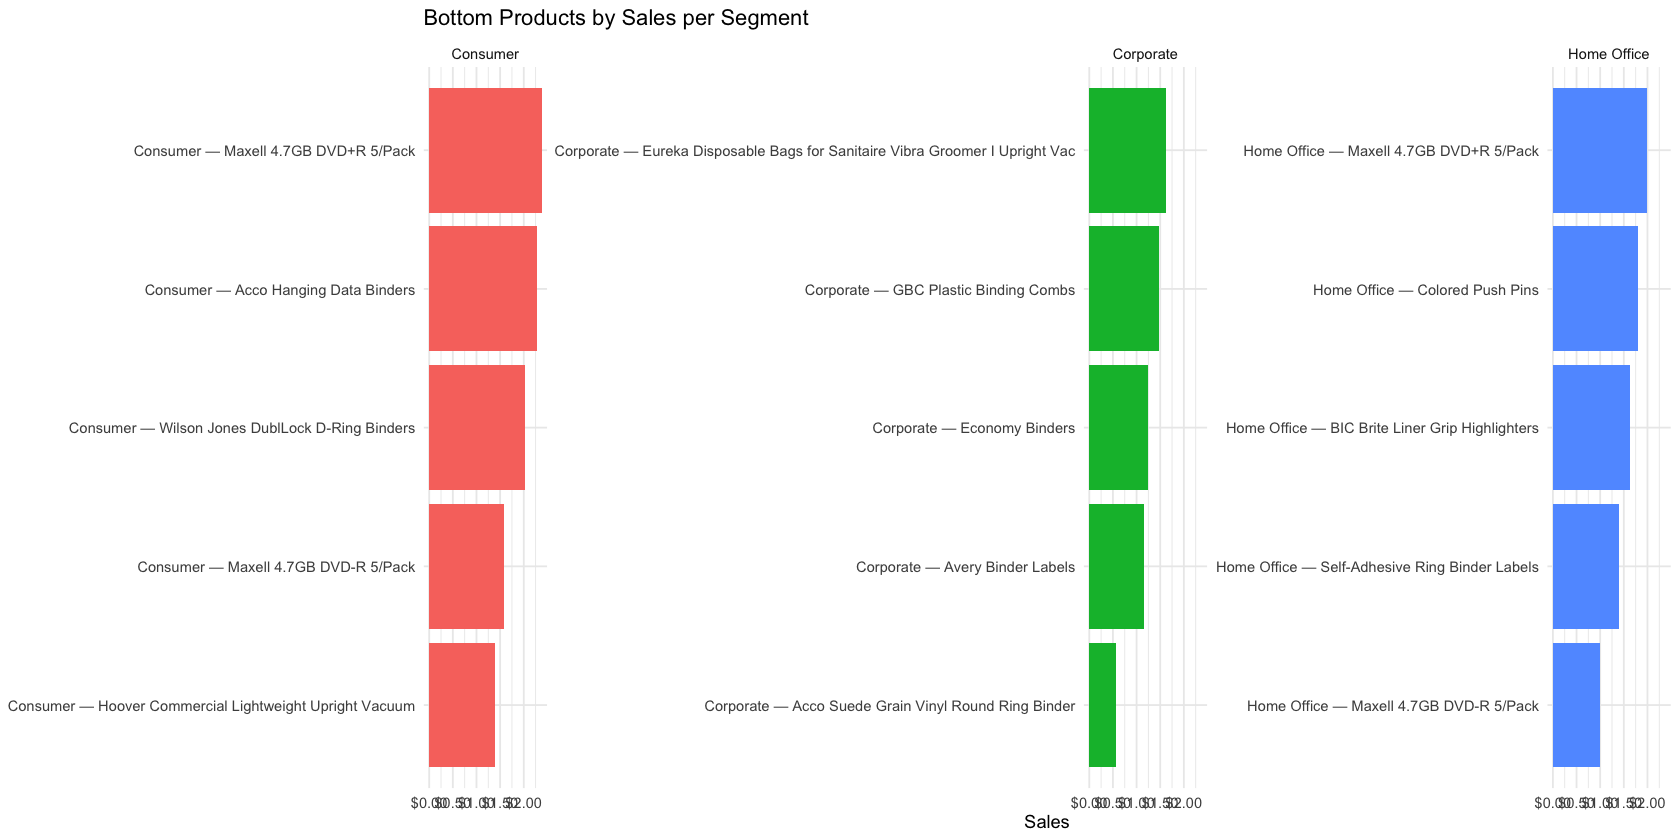

In [20]:
bottom_products <- orders %>%
  group_by(segment, product_name) %>%
  summarise(sales = sum(sales), .groups = "drop") %>%
  group_by(segment) %>%
  slice_min(sales, n = N, with_ties = FALSE) %>%
  ungroup() %>%
  mutate(product_in_segment = paste0(segment, " — ", product_name))

options(repr.plot.width = 14, repr.plot.height = 7)
ggplot(bottom_products, aes(reorder(product_in_segment, sales), sales, fill = segment)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  facet_wrap(~ segment, scales = "free_y") +
  scale_y_continuous(labels = scales::dollar_format()) +
  labs(title = "Bottom Products by Sales per Segment", x = NULL, y = "Sales") +
  theme_minimal()

# Profitability & Risk by Segment

### Profit margin distribution by segment (box/violin)

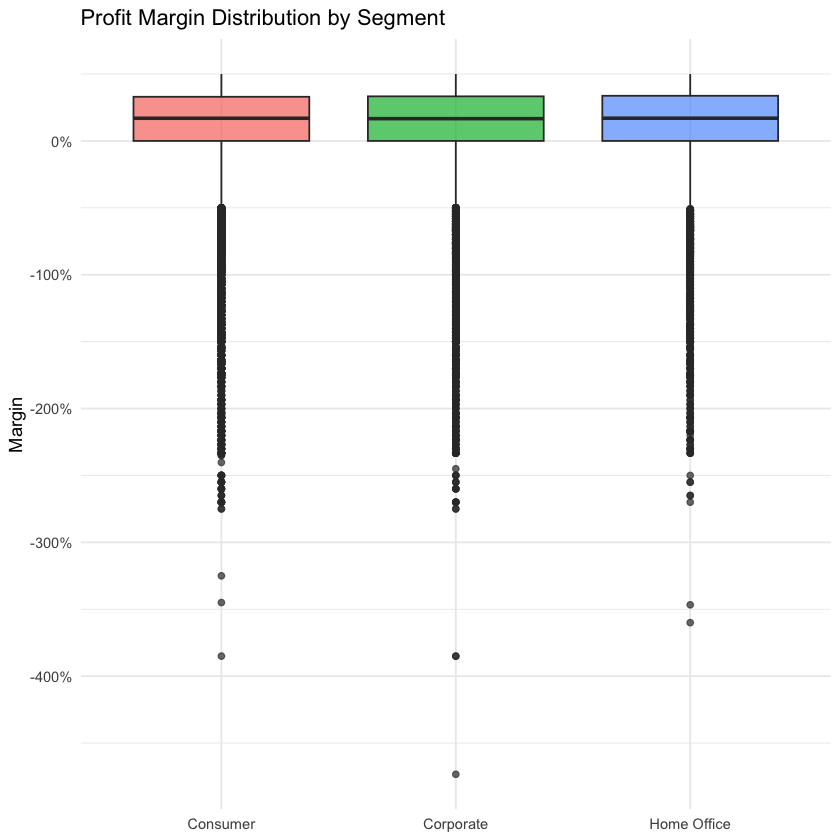

In [13]:
orders %>%
    mutate(margin = profit / sales) %>%
    ggplot(aes(segment, margin, fill = segment)) +
    geom_boxplot(alpha = 0.7) +
    scale_y_continuous(labels = scales::percent) +
    labs(title = "Profit Margin Distribution by Segment", x = NULL, y = "Margin") +
    theme_minimal() +
    theme(legend.position = "none")

### Discount vs Profit by segment (faceted scatter)

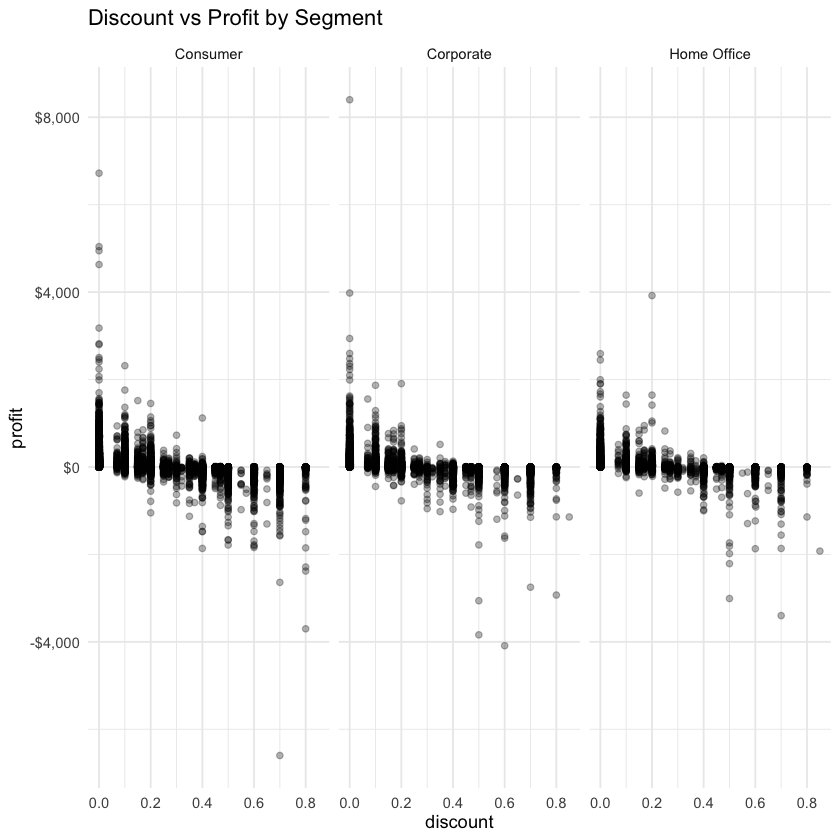

In [14]:
orders %>%
    ggplot(aes(discount, profit)) +
    geom_point(alpha = 0.3) +
    facet_wrap(~ segment) +
    scale_y_continuous(labels = scales::dollar_format()) +
    labs(title = "Discount vs Profit by Segment") +
    theme_minimal()

### Return rate by segment

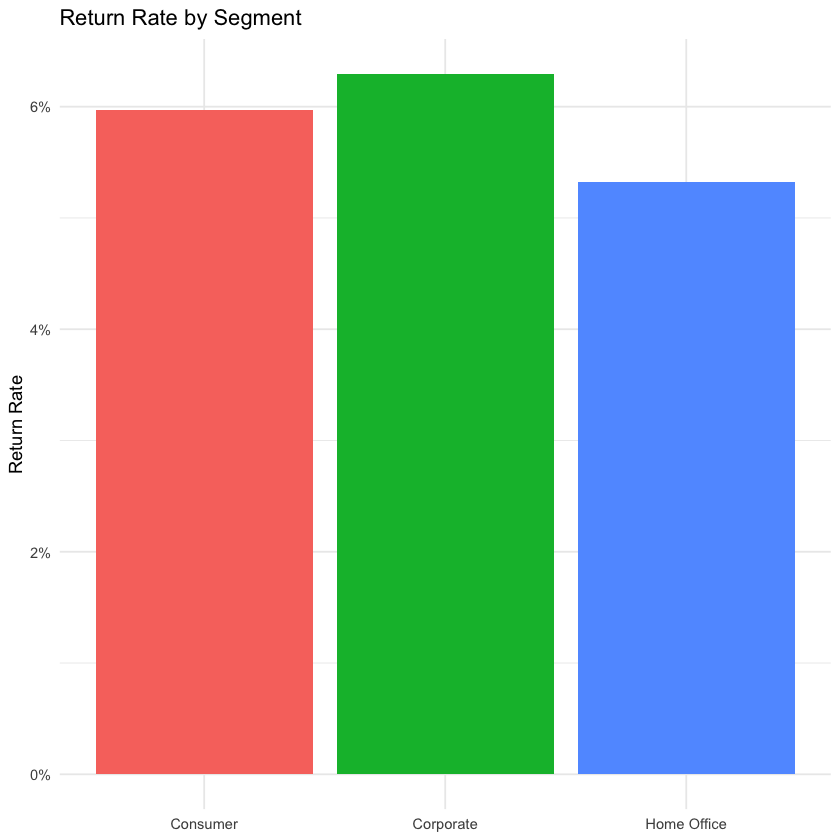

In [17]:
orders_with_returns <- orders %>%
    left_join(
        returns %>% distinct(order_id) %>% mutate(returned = 1),
        by = "order_id"
    ) %>%
    mutate(returned = if_else(is.na(returned), 0, returned))

orders_with_returns %>%
    group_by(segment) %>%
    summarise(return_rate = mean(returned)) %>%
    ggplot(aes(segment, return_rate, fill = segment)) +
    geom_col() +
    scale_y_continuous(labels = scales::percent) +
    labs(title = "Return Rate by Segment", x = NULL, y = "Return Rate") +
    theme_minimal() +
    theme(legend.position = "none")

# Concentration & Dependency (Segment)

### Top X% of products vs segment sales contribution

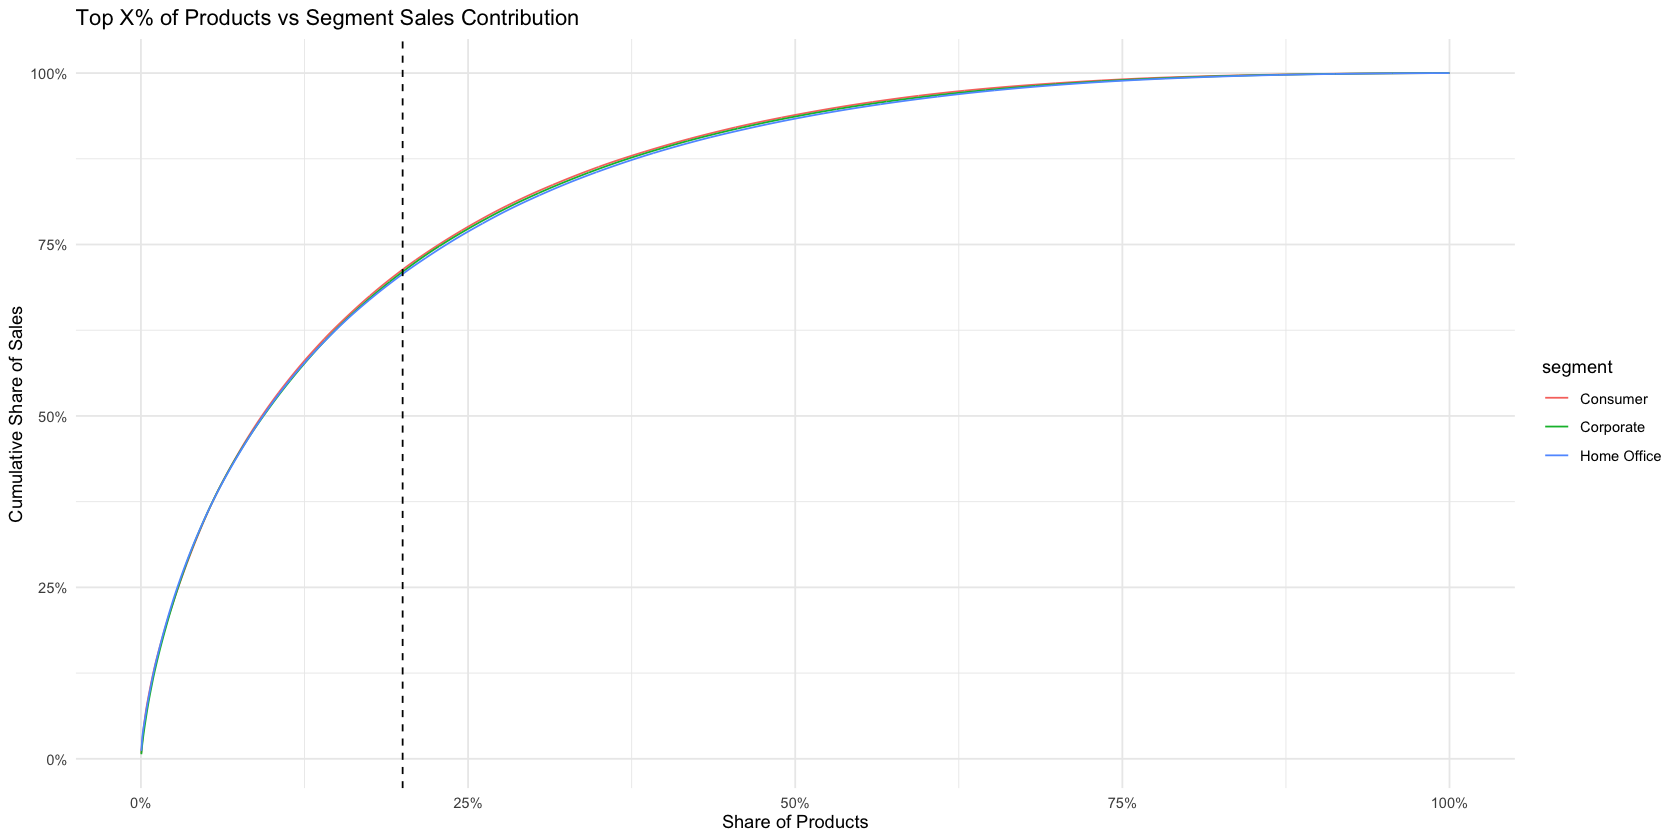

In [24]:
X <- 0.2

segment_product_sales <- orders %>%
    group_by(segment, product_name) %>%
    summarise(sales = sum(sales), .groups = "drop") %>%
    group_by(segment) %>%
    arrange(desc(sales)) %>%
    mutate(
        cum_sales = cumsum(sales),
        total_sales = sum(sales),
        cum_share = cum_sales / total_sales,
        product_rank = row_number(),
        product_pct = product_rank / n()
    )

segment_product_sales %>%
    ggplot(aes(product_pct, cum_share, color = segment)) +
    geom_line() +
    geom_vline(xintercept = X, linetype = "dashed") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_continuous(labels = scales::percent) +
    labs(
        title = "Top X% of Products vs Segment Sales Contribution",
        x = "Share of Products",
        y = "Cumulative Share of Sales"
    ) +
    theme_minimal()

### Top X% of customers vs segment sales contribution 

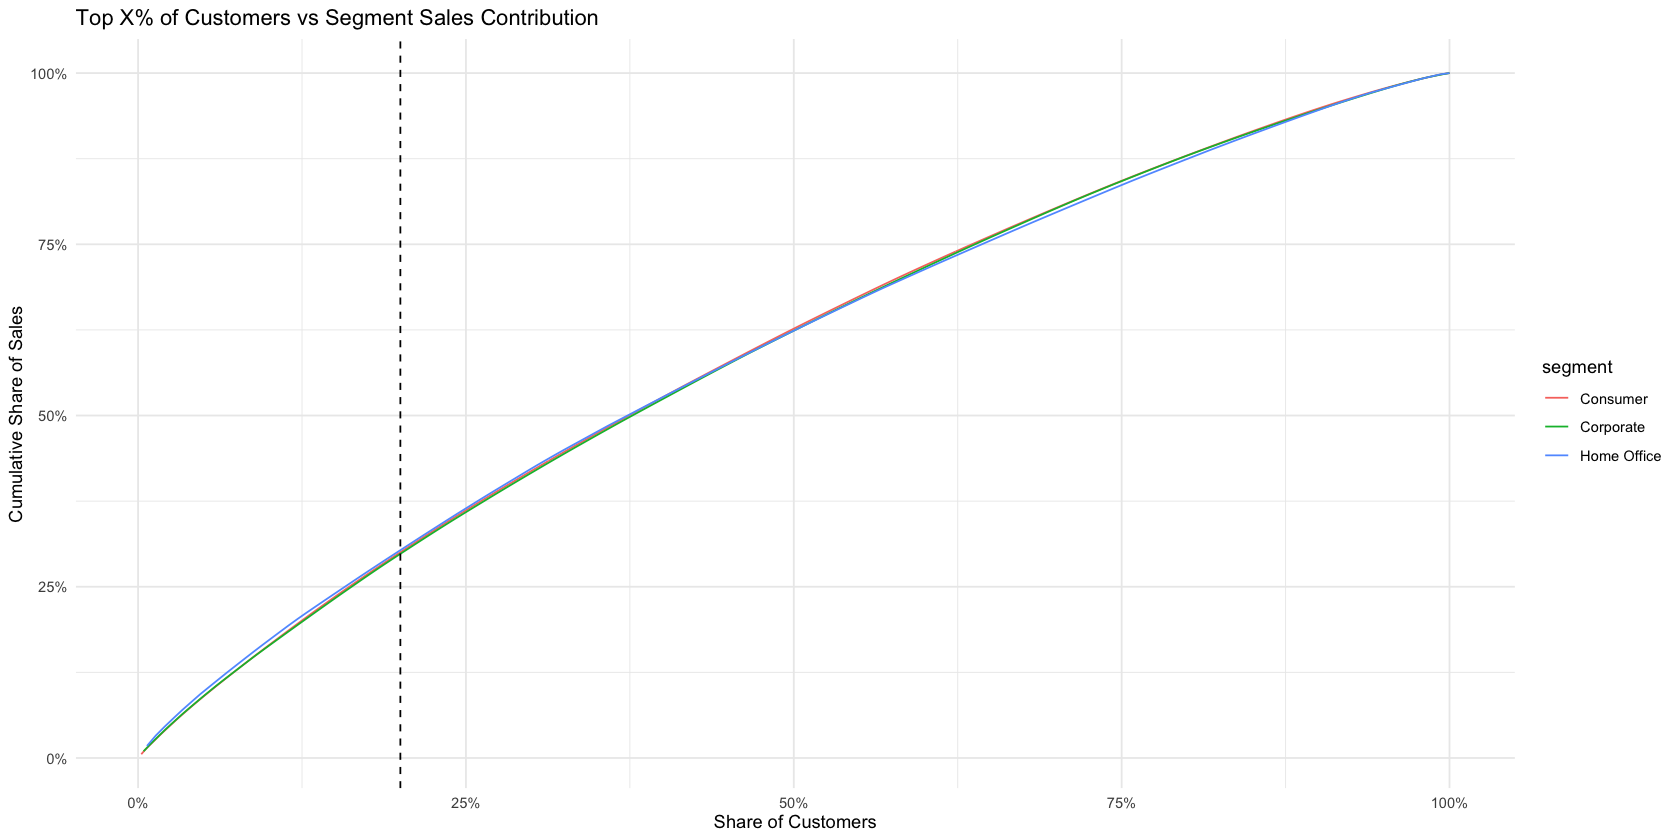

In [26]:
segment_customer_sales <- orders %>%
    group_by(segment, customer_name) %>%
    summarise(sales = sum(sales), .groups = "drop") %>%
    group_by(segment) %>%
    arrange(desc(sales)) %>%
    mutate(
        cum_sales = cumsum(sales),
        total_sales = sum(sales),
        cum_share = cum_sales / total_sales,
        customer_pct = row_number() / n()
  )

segment_customer_sales %>%
    ggplot(aes(customer_pct, cum_share, color = segment)) +
    geom_line() +
    geom_vline(xintercept = X, linetype = "dashed") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_continuous(labels = scales::percent) +
    labs(
        title = "Top X% of Customers vs Segment Sales Contribution",
        x = "Share of Customers",
        y = "Cumulative Share of Sales"
    ) +
    theme_minimal()

# Executive Overview (Organization-Wide)

### Total Sales, Profit, Margin (single KPI-style bars)

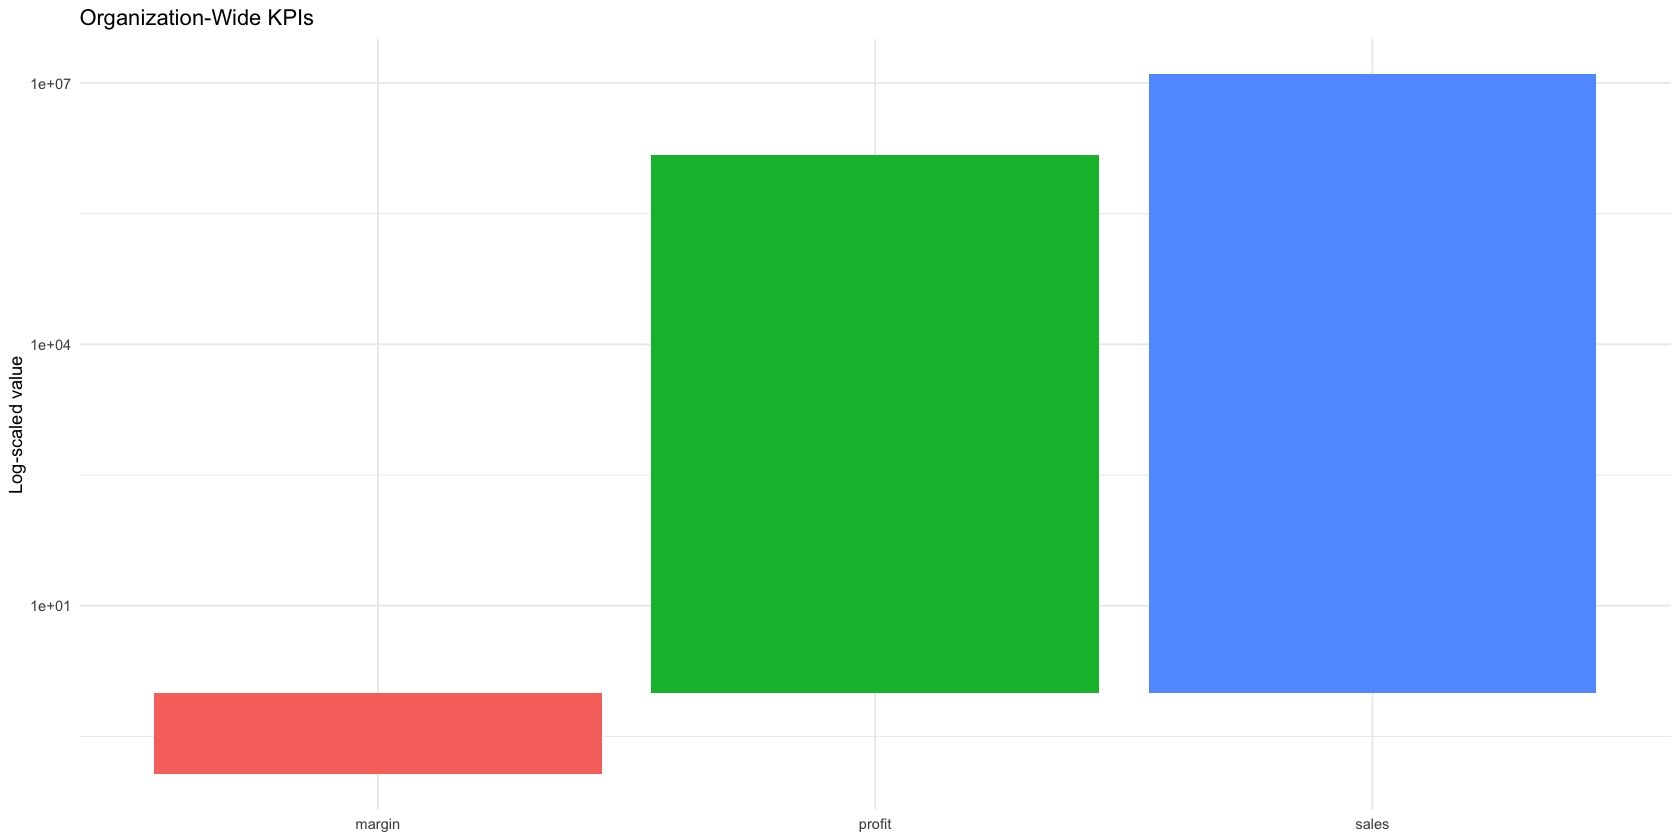

In [47]:
org_kpis <- orders %>%
    summarise(
        sales = sum(sales),
        profit = sum(profit),
        margin = sum(profit) / sum(sales)
    ) %>%
    pivot_longer(everything(), names_to = "metric", values_to = "value")

ggplot(org_kpis, aes(metric, value, fill = metric)) +
    geom_col() +
    scale_y_continuous(trans = "log10") +
    labs(title = "Organization-Wide KPIs", x = NULL, y = "Log-scaled value") +
    theme_minimal() +
    theme(legend.position = "none")

### Orders vs Profit (scatter or dual-axis bar)

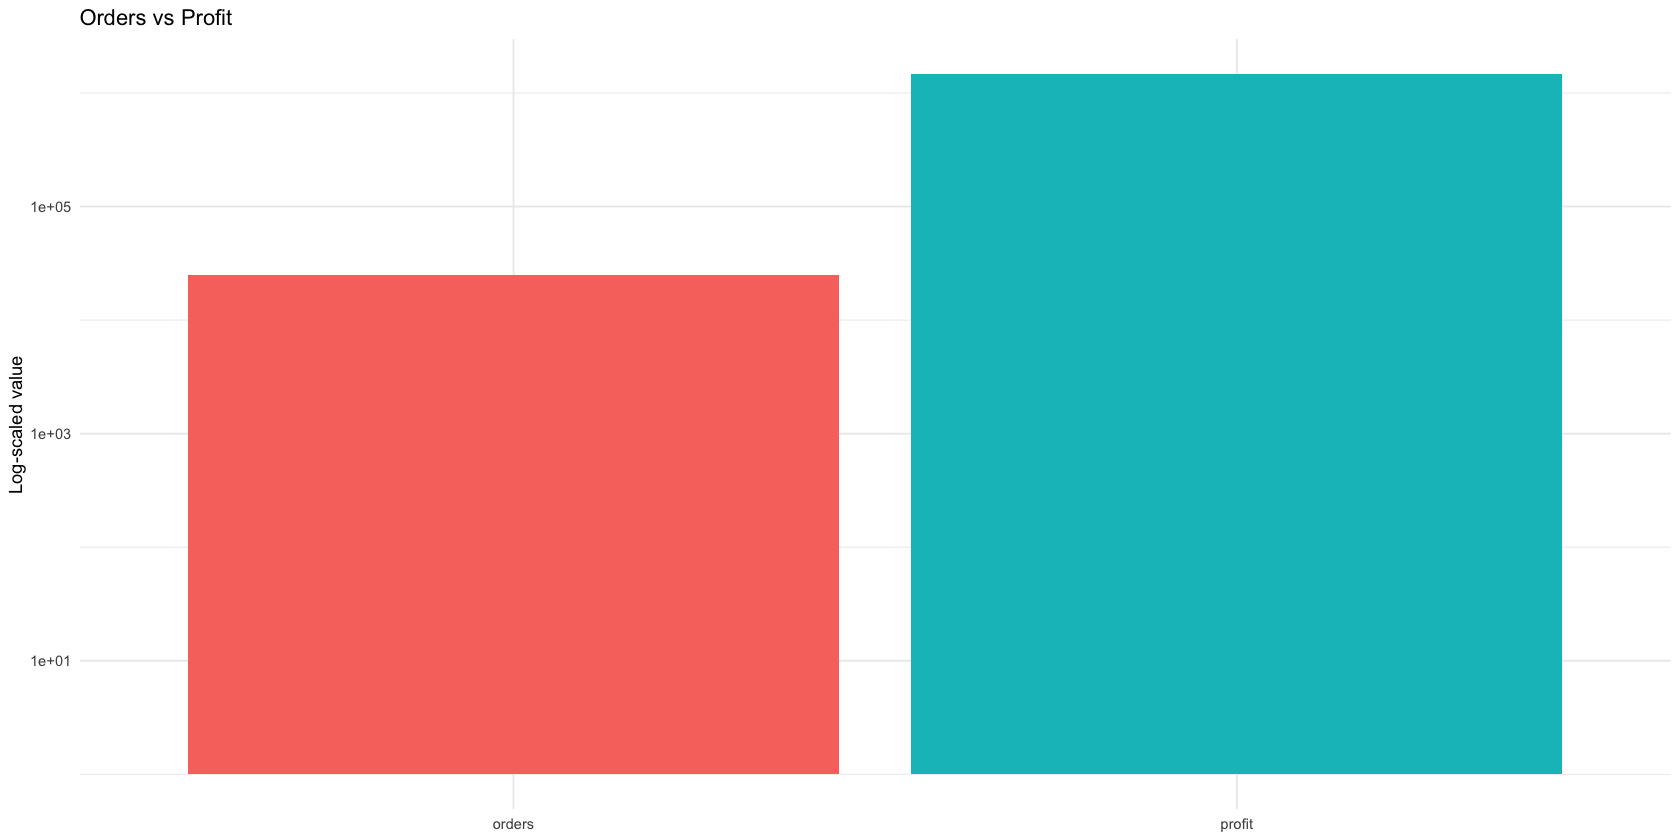

In [48]:
orders %>%
    summarise(
        orders = n_distinct(order_id),
        profit = sum(profit)
    ) %>%
    pivot_longer(everything()) %>%
    ggplot(aes(name, value, fill = name)) +
    geom_col() +
    scale_y_continuous(trans = "log10") +
    labs(title = "Orders vs Profit", x = NULL, y = "Log-scaled value") +
    theme_minimal() +
    theme(legend.position = "none")

# Performance by Organizational Dimension

### Sales, Orders, and Profit by Region Manager

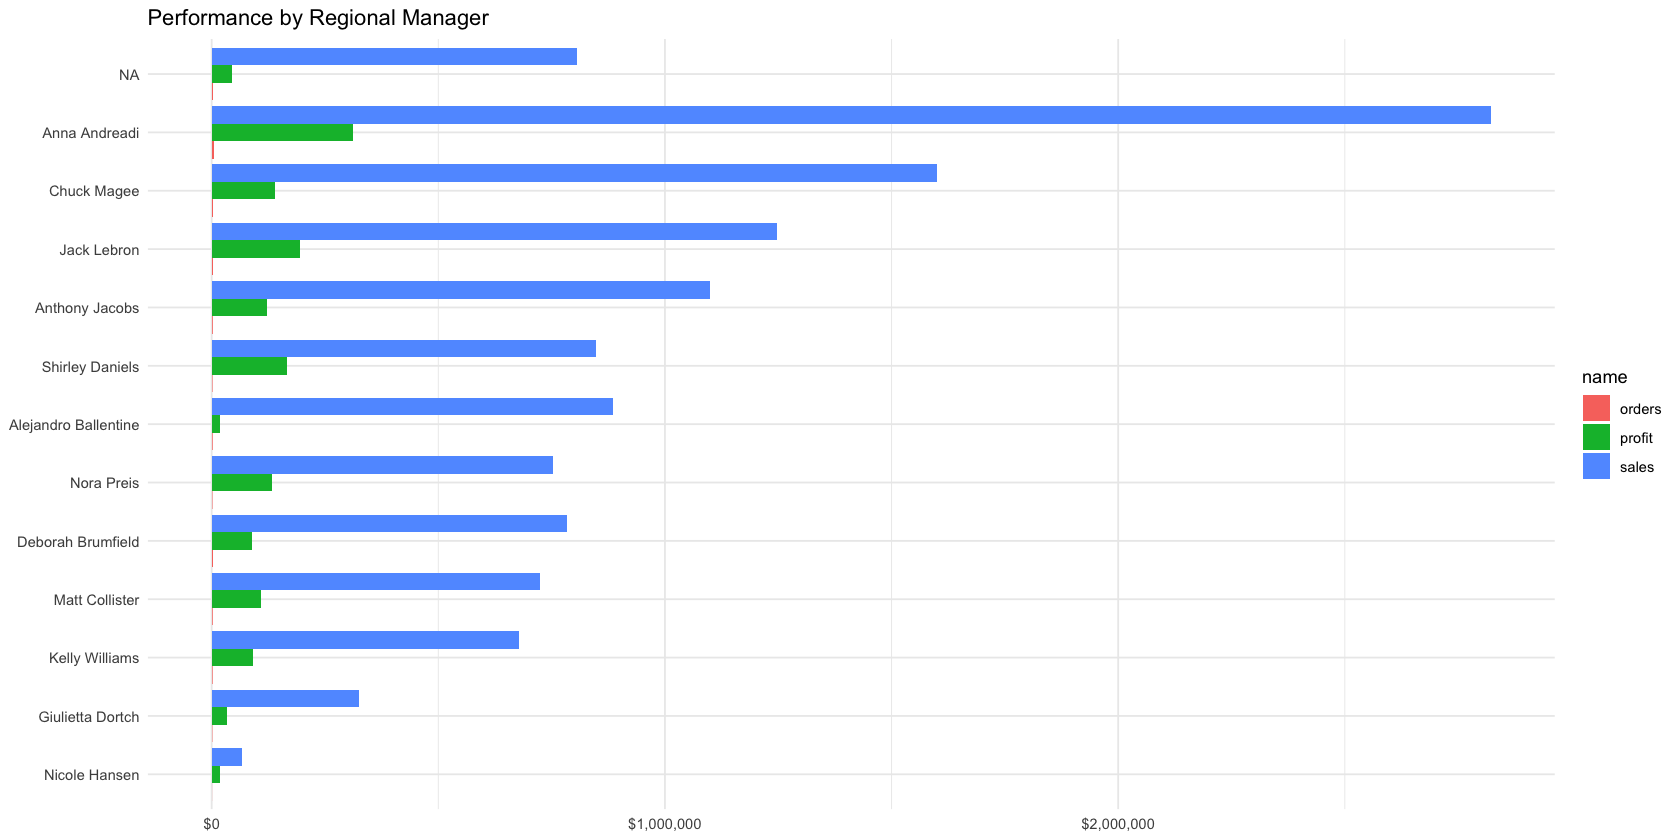

In [30]:
orders_org <- orders %>%
    left_join(people, by = "region")

orders_org %>%
    group_by(person) %>%
    summarise(
        sales = sum(sales),
        profit = sum(profit),
        orders = n_distinct(order_id)
    ) %>%
    pivot_longer(-person) %>%
    ggplot(aes(reorder(person, value), value, fill = name)) +
    geom_col(position = "dodge") +
    coord_flip() +
    scale_y_continuous(labels = scales::dollar_format()) +
    labs(title = "Performance by Regional Manager", x = NULL, y = NULL) +
    theme_minimal()

# Operational Efficiency Signals

### Profit margin distribution by regional manager

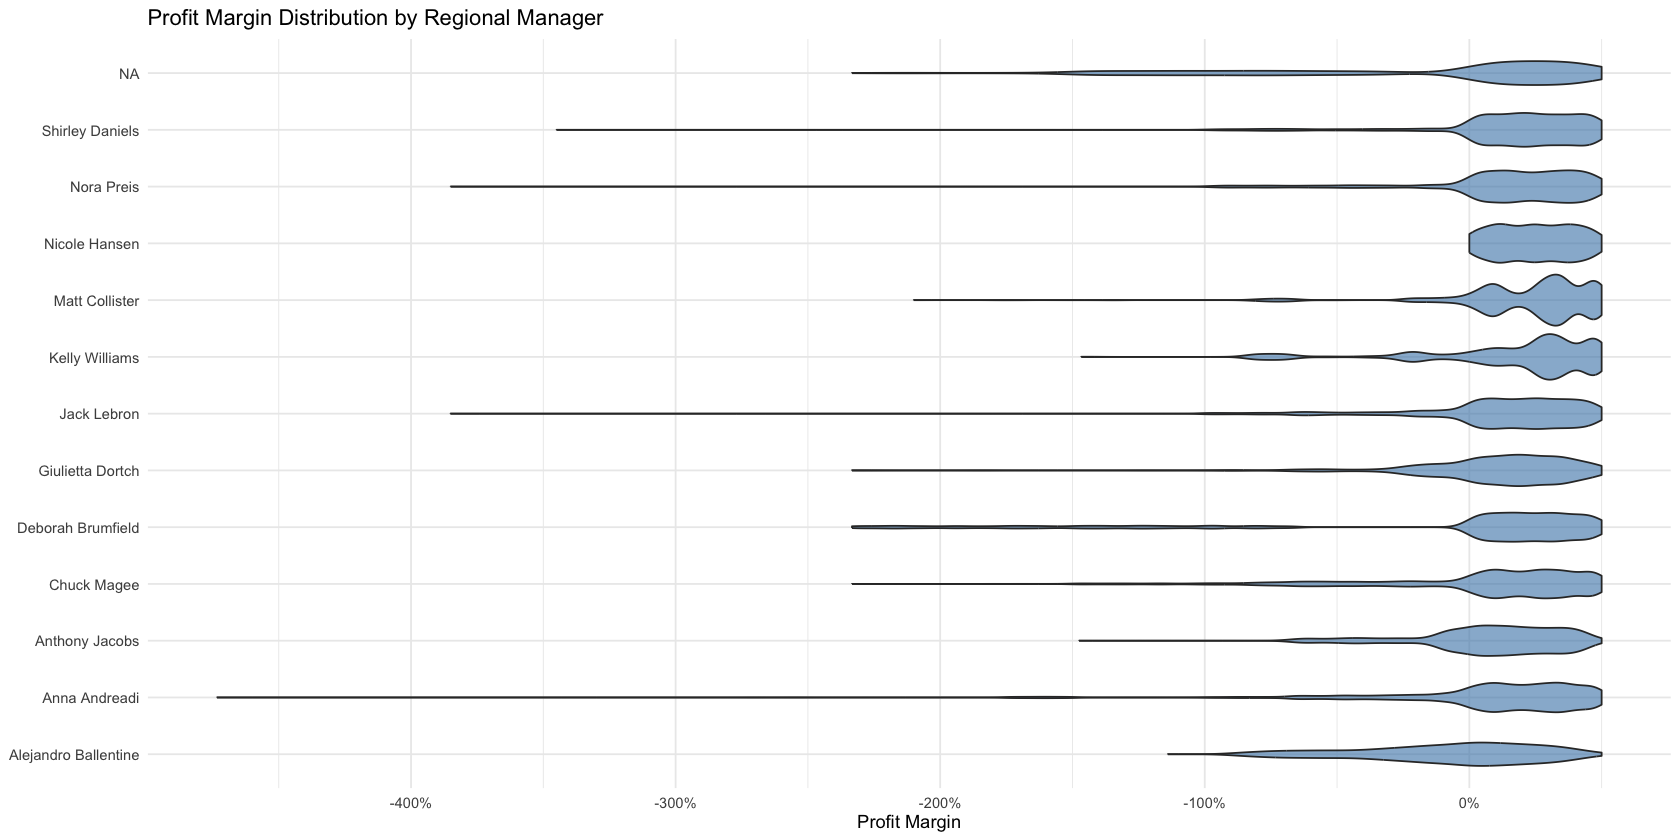

In [32]:
orders_org %>%
    mutate(margin = profit / sales) %>%
    ggplot(aes(person, margin)) +
    geom_violin(fill = "steelblue", alpha = 0.6) +
    coord_flip() +
    scale_y_continuous(labels = scales::percent) +
    labs(title = "Profit Margin Distribution by Regional Manager",
        x = NULL, y = "Profit Margin") +
    theme_minimal()

### Discount levels by regional manager

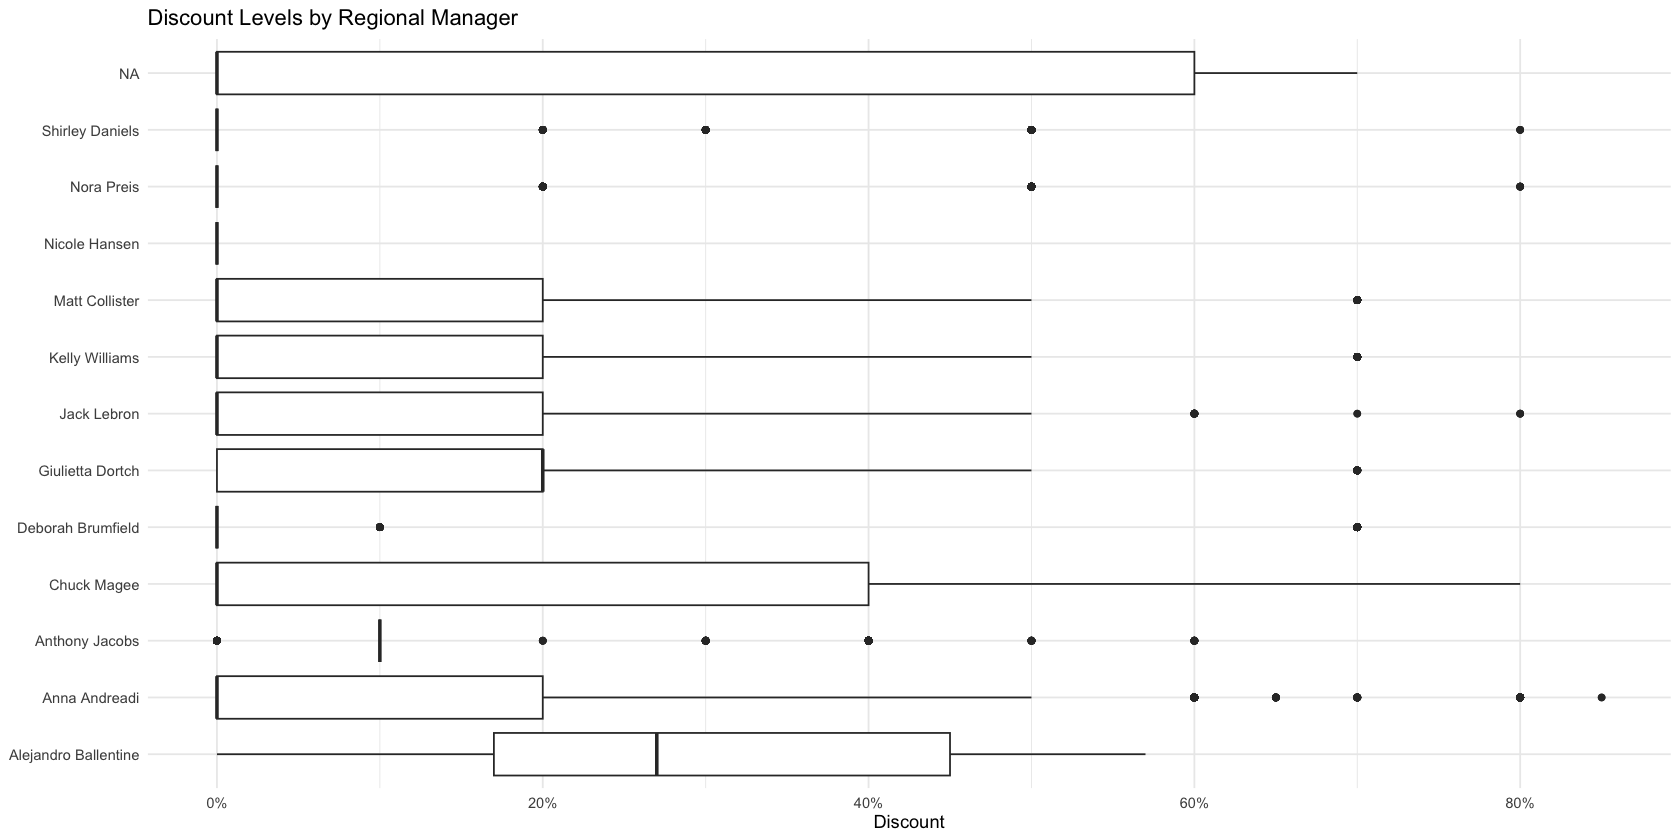

In [33]:
orders_org %>%
  ggplot(aes(person, discount)) +
  geom_boxplot() +
  coord_flip() +
  scale_y_continuous(labels = scales::percent) +
  labs(title = "Discount Levels by Regional Manager",
       x = NULL, y = "Discount") +
  theme_minimal()

### Return rates by regional manager

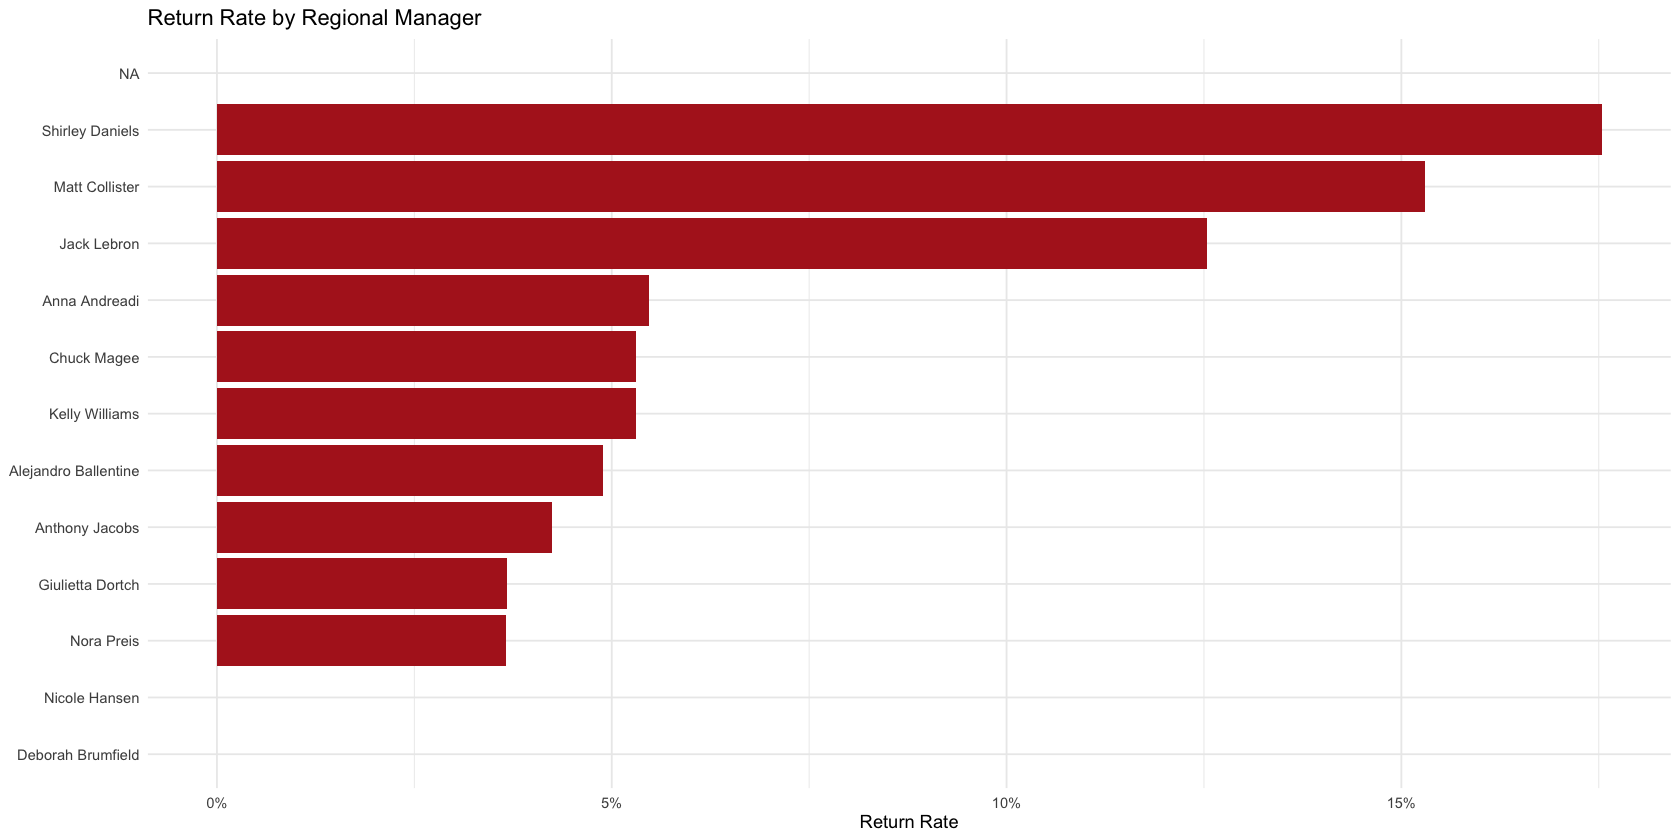

In [34]:
orders_with_returns %>%
    left_join(people, by = "region") %>%
    group_by(person) %>%
    summarise(return_rate = mean(returned)) %>%
    ggplot(aes(reorder(person, return_rate), return_rate)) +
    geom_col(fill = "firebrick") +
    coord_flip() +
    scale_y_continuous(labels = scales::percent) +
    labs(title = "Return Rate by Regional Manager",
        x = NULL, y = "Return Rate") +
    theme_minimal()

# Risk & Volatility (Organizational)

### Profit volatility by regional manager (SD)

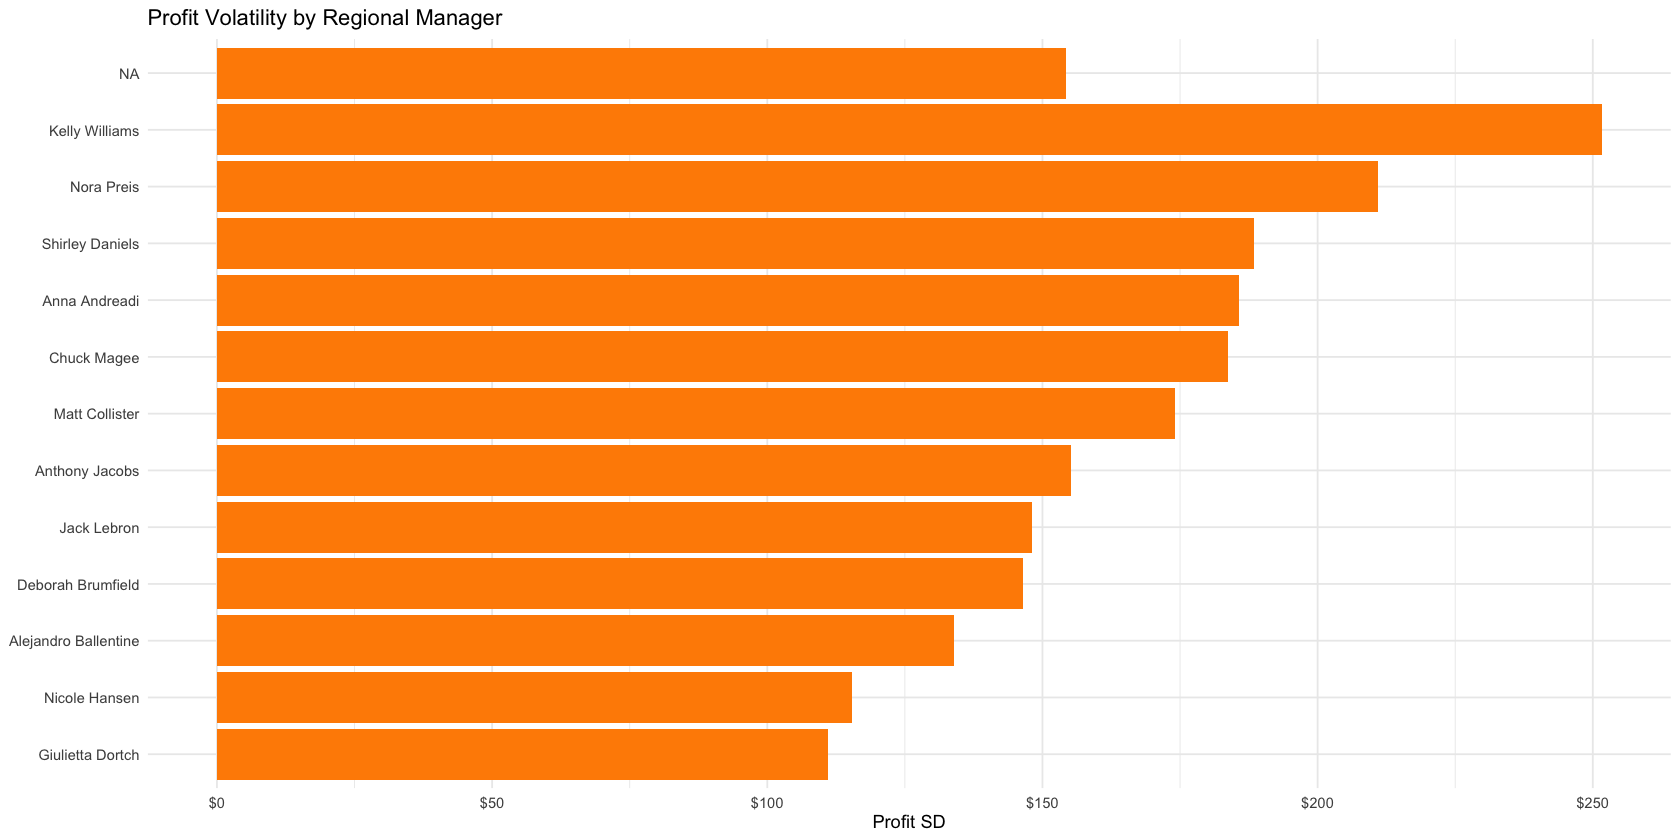

In [36]:
orders_org %>%
    group_by(person) %>%
    summarise(profit_sd = sd(profit)) %>%
    ggplot(aes(reorder(person, profit_sd), profit_sd)) +
    geom_col(fill = "darkorange") +
    coord_flip() +
    scale_y_continuous(labels = scales::dollar_format()) +
    labs(title = "Profit Volatility by Regional Manager",
        x = NULL, y = "Profit SD") +
    theme_minimal()

### Return-rate volatility by regional manager

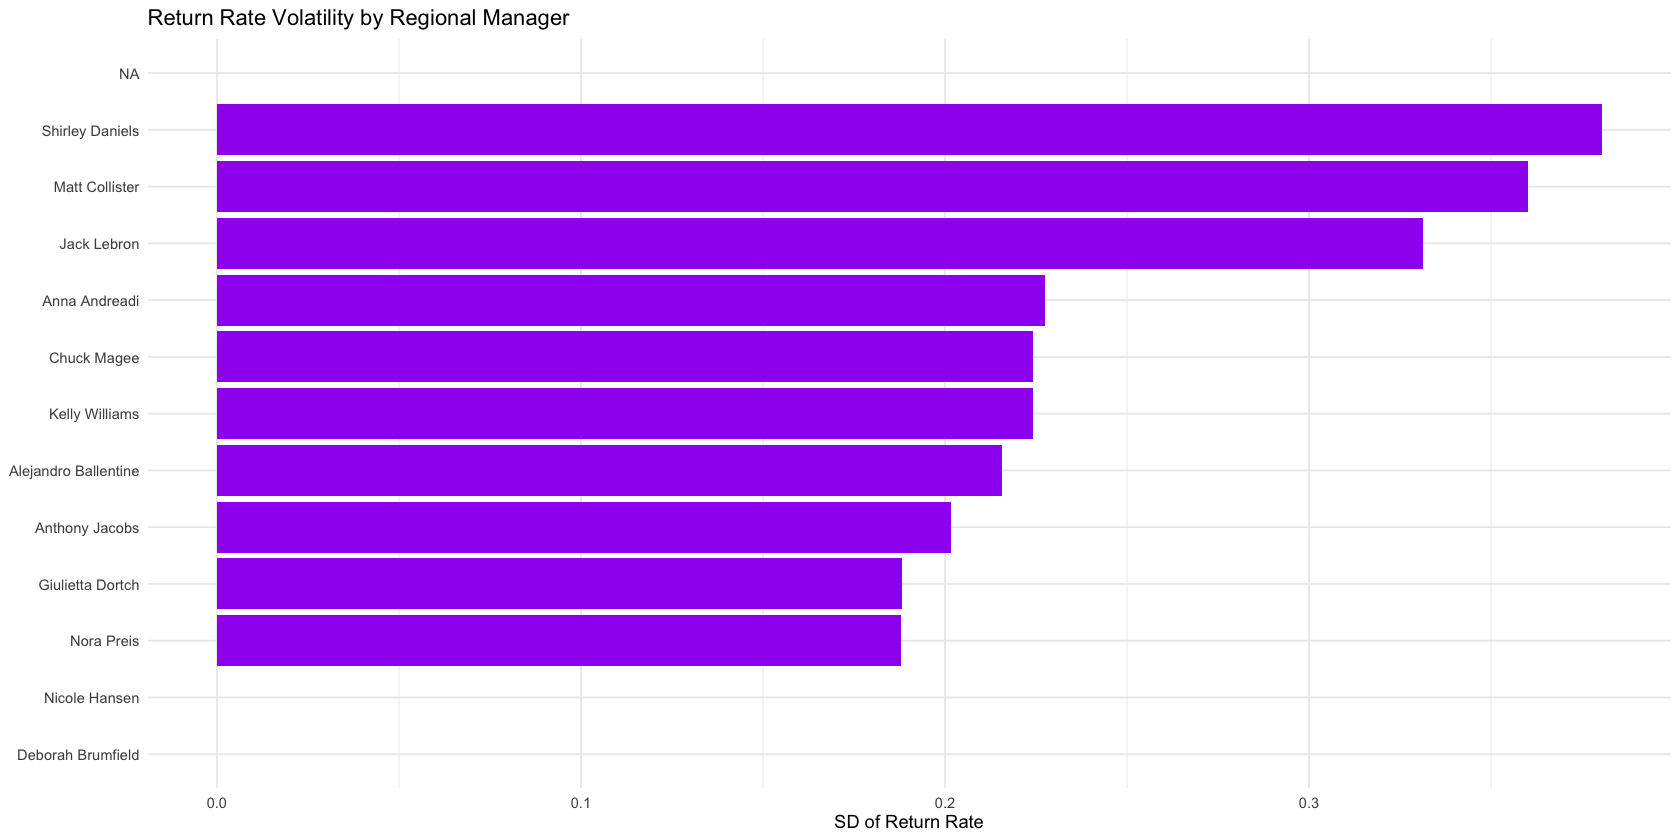

In [37]:
orders_with_returns %>%
    left_join(people, by = "region") %>%
    group_by(person) %>%
    summarise(return_sd = sd(returned)) %>%
    ggplot(aes(reorder(person, return_sd), return_sd)) +
    geom_col(fill = "purple") +
    coord_flip() +
    labs(title = "Return Rate Volatility by Regional Manager",
        x = NULL, y = "SD of Return Rate") +
    theme_minimal()

### Discount sensitivity (discount vs profit, faceted)

`geom_smooth()` using formula = 'y ~ x'


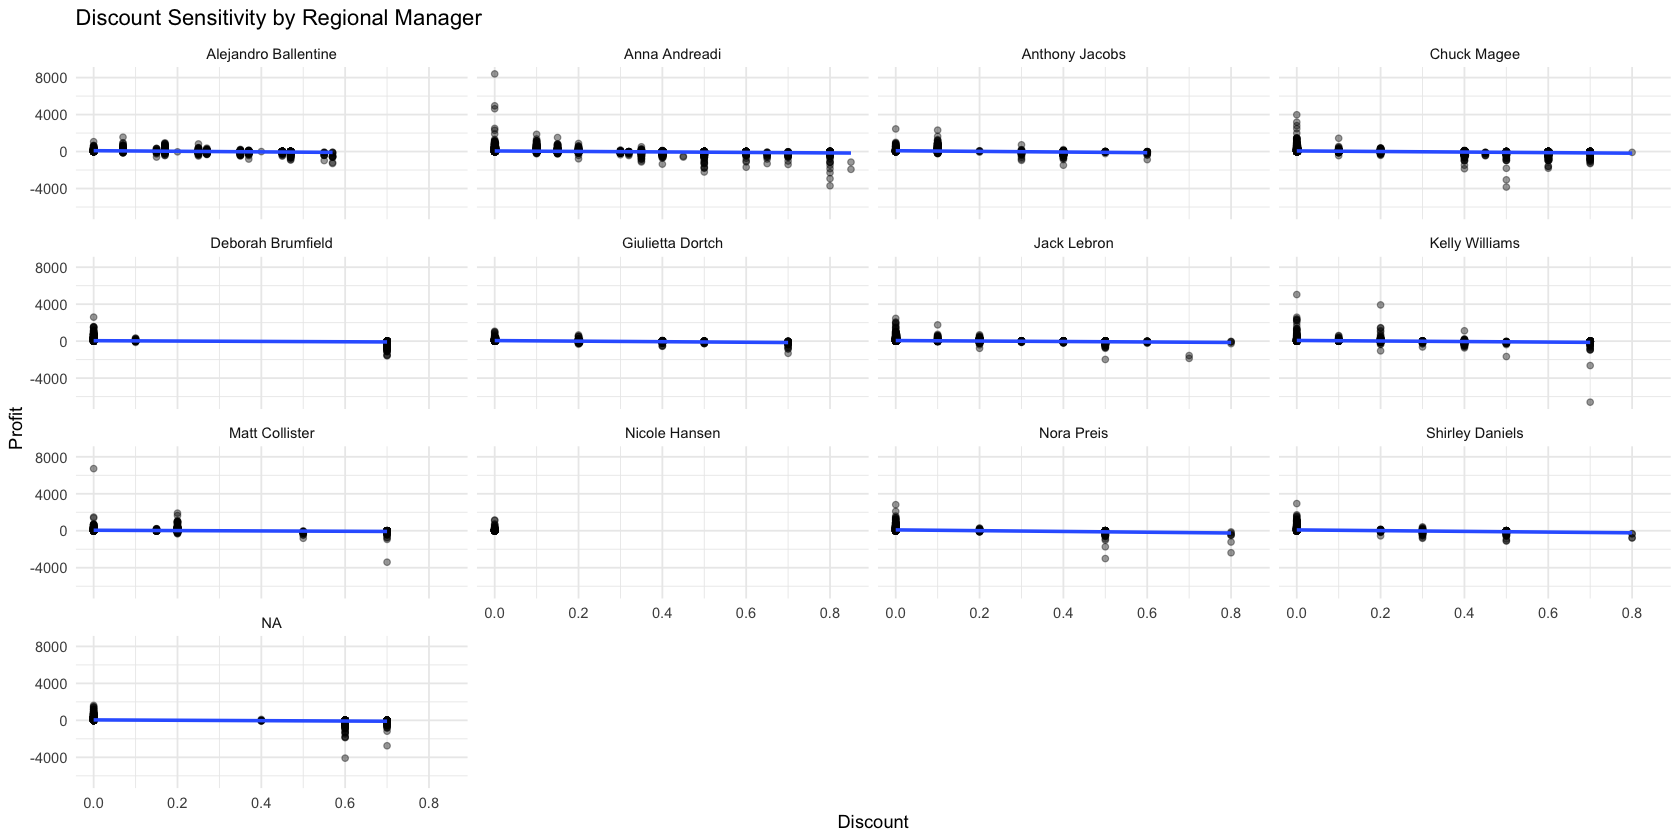

In [39]:
orders_org %>%
    ggplot(aes(discount, profit)) +
    geom_point(alpha = 0.4) +
    geom_smooth(method = "lm", se = FALSE) +
    facet_wrap(~ person) +
    labs(title = "Discount Sensitivity by Regional Manager",
        x = "Discount", y = "Profit") +
    theme_minimal()

# Concentration & Dependency (Organizational)

### Top X% of regional managers vs total profit contribution (pareto style)

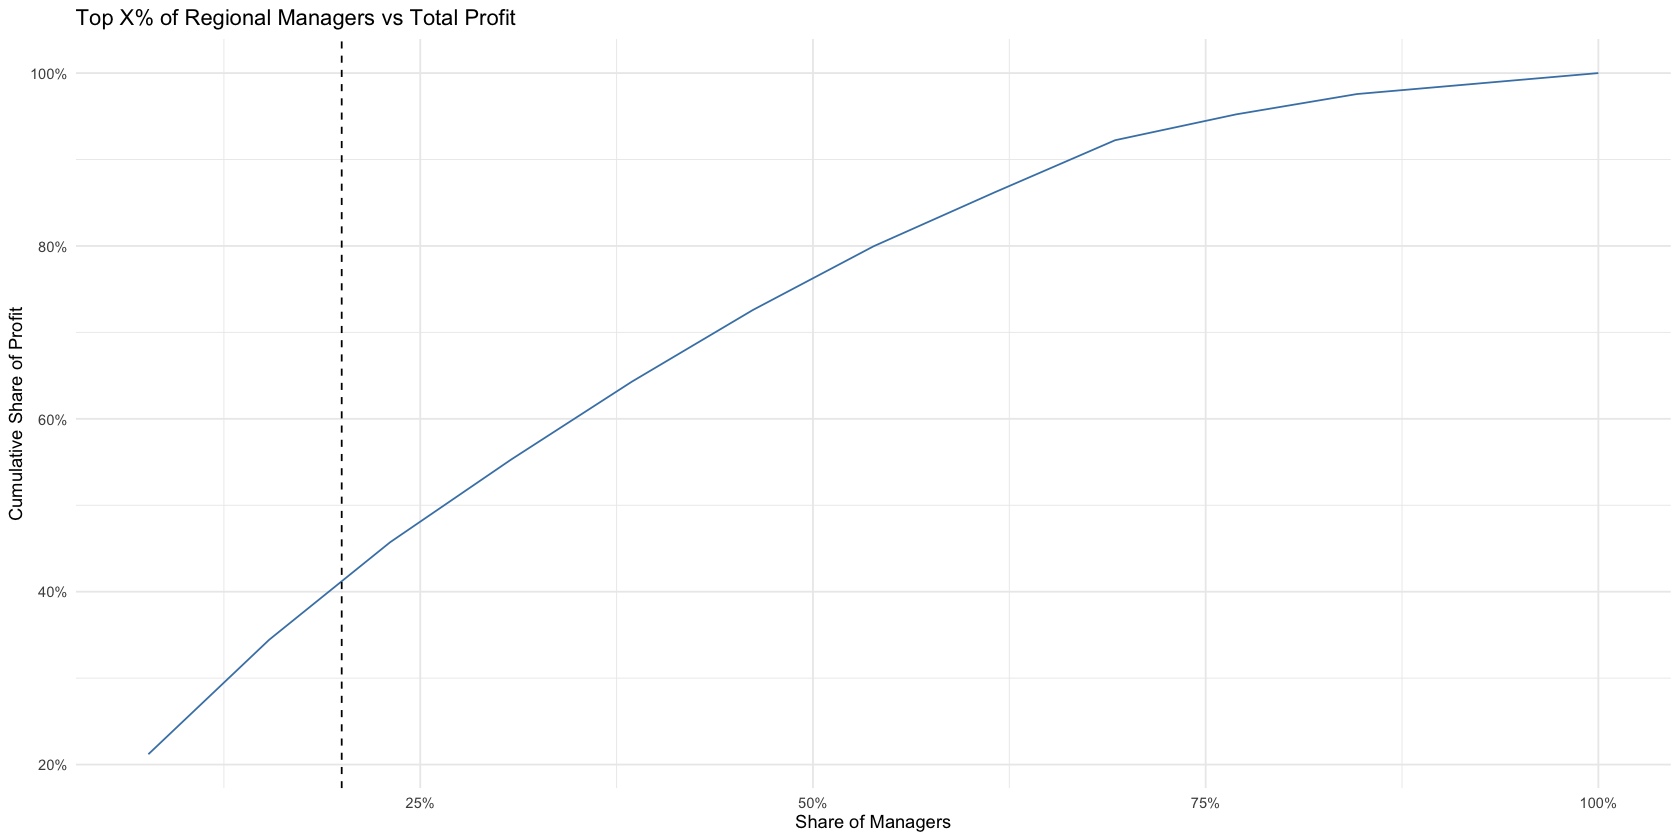

In [41]:
manager_profit <- orders_org %>%
    group_by(person) %>%
    summarise(profit = sum(profit)) %>%
    arrange(desc(profit)) %>%
    mutate(
        cum_profit = cumsum(profit),
        total_profit = sum(profit),
        cum_share = cum_profit / total_profit,
        manager_pct = row_number() / n()
    )

manager_profit %>%
    ggplot(aes(manager_pct, cum_share)) +
    geom_line(color = "steelblue") +
    geom_vline(xintercept = X, linetype = "dashed") +
    scale_x_continuous(labels = scales::percent) +
    scale_y_continuous(labels = scales::percent) +
    labs(
        title = "Top X% of Regional Managers vs Total Profit",
        x = "Share of Managers",
        y = "Cumulative Share of Profit"
    ) +
    theme_minimal()